In [4]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import tensorflow as tf

from ChestCancerClassifier.entity.config_entity import TrainModelConfig
from ChestCancerClassifier.config.configuration import ConfigurationManager

os.chdir("../")
%pwd

2025-03-05 10:42:42.531017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 10:42:45.278666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741167766.277153  251076 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741167766.540044  251076 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 10:42:48.981440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

'/mnt/c/Users/DataScience/Documents/GitHub/Chest_Cancer_Classification_MLOps'

In [5]:
class ListPaths:
    def __init__(self):
        pass 

    def list_paths(self, img_dir_path: Path) -> list[Path]:
        """
        Generates a list of paths to all files in a given folder.

        This function traverses the specified folder and all its subfolders,
        then creates a list of full paths to the files found therein.

        Args:
            folder (Path): The path to the folder that needs to be searched.

        Returns:
            list: A list of full paths to the files located in the given folder and its subfolders.
        """
        paths = []
        
        for root, dirs, files in os.walk(img_dir_path):
            for file in files:
                paths.append(os.path.join(root, file))

        return paths

In [6]:
try:
    config = ConfigurationManager()
    model_training_config = config.get_train_model_config()
except Exception as e:
    raise e

model_training_config.root_dir

[2025-03-05 10:43:15,615]: INFO: common: read_yaml: yaml file: config/config.yaml loaded successfully!
[2025-03-05 10:43:15,623]: INFO: common: read_yaml: yaml file: params.yaml loaded successfully!
[2025-03-05 10:43:15,625]: INFO: common: create_directories: Created directory at: artifacts
[2025-03-05 10:43:15,627]: INFO: common: create_directories: Created directory at: artifacts/train_model/


PosixPath('artifacts/train_model')

In [7]:
ls = ListPaths()
paths = ls.list_paths(model_training_config.ingested_data_path)
paths

['artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000108 (3).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000109 (2).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000109 (4).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000109 (5).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000112 (2).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000113 (7).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000114 (5).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000114.png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000115 (4).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000115 (8).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000115.png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000116 (5).png',
 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000116 (7).png',
 'artif

In [5]:
image = tf.io.read_file(paths[0])
image = tf.image.decode_image(image, channels=3)
image = tf.cast(image, tf.float32) / 255.0
image.numpy().shape

I0000 00:00:1740569454.110594   80212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


(282, 381, 3)

In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU')) #show detail GPUs
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [9]:
image.numpy().shape == (282,381,3)

NameError: name 'image' is not defined

In [ ]:
def retrieve_num_subdirectories(folder: Path, num_classes: int, folder_deep: int = 0) -> dict[str: Path]:
    """
    Returns a dict of the first num_classes directories at a given depth.

    Args:
        folder (str): The root folder to start the search from.
        num_classes (int): The number of directories to return.
        folder_deep (int): The depth of subfolders to be considered.

    Returns:
        dict: A dictionary containing class name as a key and directory path as value
    """
    dir_dict = {}
    for i, (root, dirs, files) in enumerate(os.walk(folder)):
        if i == folder_deep:
            for j, dir in enumerate(dirs):
                dir_dict[dir] = os.path.join(root,dir)
                # dir_list.append(os.path.join(root, dir))
                if j >= (num_classes - 1):
                    break
        else:
            continue
    
    return dir_dict

In [ ]:
dir_list = retrieve_num_subdirectories(model_training_config.ingested_data_path, num_classes = 4, folder_deep = 2)
dir_list

{'adenocarcinoma': 'artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma',
 'large.cell.carcinoma': 'artifacts/data_ingestion/.kaggle/Data/test/large.cell.carcinoma',
 'normal': 'artifacts/data_ingestion/.kaggle/Data/test/normal',
 'squamous.cell.carcinoma': 'artifacts/data_ingestion/.kaggle/Data/test/squamous.cell.carcinoma'}

In [53]:
def check_targets_in_list(targets: list[str], list_of_strings: list[str]) -> dict[str, bool]:
    results = {}
    for target in targets:
        # Check if the target is exactly in the list
        if target in list_of_strings:
            results[target] = True
            continue  # No need to check further for this target
        
        # If not found exactly, check if the target is a substring of any string in the list
        for string in list_of_strings:
            if target in string:
                results[target] = True
                break  # No need to check further for this target
        else:
            results[target] = False  # If not found as a substring either
    
    return results

# Example usage:
targets = ["str1", "str2", "ass"]
list_of_strings = ["str1 abc", "str2", "str3", "str4"]

# Check if targets are in the list or part of any string
results = check_targets_in_list(targets, list_of_strings)
print("Results:")
for target, found in results.items():
    print(f"Target '{target}': {found}")


Results:
Target 'str1': True
Target 'str2': True
Target 'ass': False


In [84]:
dir_val_list = ["train","test","val"]
for i, (root, dirs, files) in enumerate(os.walk(model_training_config.ingested_data_path)):
    print(f"iterator:{i}, root:{root}, dirs:{dirs}, files:{files}")
    abc = check_targets_in_list(dir_val_list, dirs)
    if not check_train_test_val:
        check_train_test_val = [key for key, item in check_targets_in_list(dir_val_list, dirs).items() if item]
    print(check_train_test_val)

iterator:0, root:artifacts/data_ingestion/.kaggle, dirs:['Data'], files:[]
['train', 'test', 'val']
iterator:1, root:artifacts/data_ingestion/.kaggle/Data, dirs:['test', 'train', 'valid'], files:[]
['train', 'test', 'val']
iterator:2, root:artifacts/data_ingestion/.kaggle/Data/test, dirs:['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'], files:[]
['train', 'test', 'val']
iterator:3, root:artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma, dirs:[], files:['000108 (3).png', '000109 (2).png', '000109 (4).png', '000109 (5).png', '000112 (2).png', '000113 (7).png', '000114 (5).png', '000114.png', '000115 (4).png', '000115 (8).png', '000115.png', '000116 (5).png', '000116 (7).png', '000116 (9).png', '000117 (4).png', '000117 (8).png', '000117.png', '000118 (5).png', '000118 (7).png', '000119 (4).png', '000119 (5).png', '000119 (6).png', '000120.png', '000121 (6).png', '000121 (7).png', '000121.png', '000122 (4).png', '000122.png', '000123 (4).png', '00012

In [76]:
abc = check_targets_in_list(dir_val_list, ["train", "test", "validation"])
print(type(list(abc.values())[0]))
for key, item in check_targets_in_list(dir_val_list, ["train", "test", "validation"]).items():
    print(f"{key}, {type(key)}, {item}, {type(item)}")
    if item == True:
        print(key)

<class 'bool'>
train, <class 'str'>, True, <class 'bool'>
train
test, <class 'str'>, True, <class 'bool'>
test
dupa, <class 'str'>, False, <class 'bool'>


In [6]:
model_training_config.ingested_data_path

PosixPath('artifacts/data_ingestion/.kaggle')

In [10]:
import os
import tensorflow as tf

class DataSplitter:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def create_data_with_split(self, img_size):
        X_train = tf.zeros((0, img_size[0], img_size[1], img_size[2]), dtype=tf.float32)
        X_test = tf.zeros((0, img_size[0], img_size[1], img_size[2]), dtype=tf.float32)
        X_val = tf.zeros((0, img_size[0], img_size[1], img_size[2]), dtype=tf.float32)

        y_train = tf.zeros((0,), dtype=tf.int32)
        y_test = tf.zeros((0,), dtype=tf.int32)
        y_val = tf.zeros((0,), dtype=tf.int32)

        class_labels = {}
        label_counter = 0
        resize = None
        
        for root, dirs, files in os.walk(self.data_dir):
            if any(folder in dirs for folder in ["train", "test", "valid"]):
                for folder in dirs:
                    folder_path = os.path.join(root, folder)
                    for class_folder in os.listdir(folder_path):
                        class_path = os.path.join(folder_path, class_folder)
                        if class_folder not in class_labels:
                            class_labels[class_folder] = label_counter
                            label_counter += 1
                        for file in os.listdir(class_path):                        
                            file_path = os.path.join(class_path, file)
                            image = tf.io.read_file(file_path)
                            image = tf.image.decode_image(image, channels=img_size[2])
                            if resize == None:
                                if image.shape.as_list() == img_size:
                                    resize = False
                                else:
                                    resize = True
                            image = tf.image.resize(image, img_size[:2])
                            image = tf.cast(image, tf.float32) / 255.0
                            if folder == "train":
                                X_train = tf.concat([X_train, tf.expand_dims(image, axis=0)], axis=0)
                                y_train = tf.concat([y_train, tf.constant([class_labels[class_folder]], dtype=tf.int32)], axis=0)
                            elif folder == "test":
                                X_test = tf.concat([X_test, tf.expand_dims(image, axis=0)], axis=0)
                                y_test = tf.concat([y_test, tf.constant([class_labels[class_folder]], dtype=tf.int32)], axis=0)
                            elif folder == "valid":
                                X_val = tf.concat([X_val, tf.expand_dims(image, axis=0)], axis=0)
                                y_val = tf.concat([y_val, tf.constant([class_labels[class_folder]], dtype=tf.int32)], axis=0)

        return X_train, X_test, X_val, y_train, y_test, y_val, class_labels


# Example usage
splitter = DataSplitter(model_training_config.ingested_data_path)
X_train, X_test, X_val, y_train, y_test, y_val, class_labels = splitter.create_data_with_split(img_size=[282,381,3])


I0000 00:00:1741167907.471089  251076 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
class_labels

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [13]:
path = "/mnt/c/Users/DataScience/Documents/GitHub/Chest_Cancer_Classification_MLOps/artifacts/data_ingestion/.kaggle/Data/test/adenocarcinoma/000108 (3).png"

In [15]:
image = tf.io.read_file(path)
image = tf.image.decode_image(image, channels=img_size[2])
image = tf.image.resize(image, [100,100])
image = tf.cast(image, tf.float32) / 255.0
image = (image.numpy()*255).astype(np.uint8)
Image.fromarray(image)


NameError: name 'img_size' is not defined

In [130]:
image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [121]:
image.shape.as_list()

[100, 100, 3]

In [ ]:
resize = None
if resize == None:
    if image.shape.as_list()== [224,224,3]:
        resize = False
    else:
        resize = True
print(resize)

True


In [ ]:
image = tf.image.decode_image(image, channels=img_size[2])
image = tf.image.resize(image, img_size[:2])
image = tf.cast(image, tf.float32) / 255.0

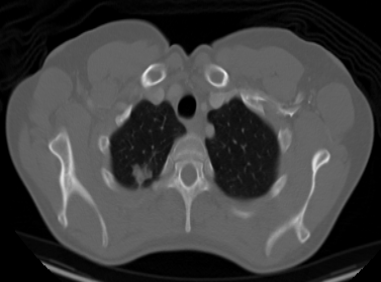

In [16]:
from PIL import Image
sample = X_train[3].numpy()
sample = sample*255
sample = sample.astype(np.uint8)
Image.fromarray(sample)

In [17]:
X_train.shape

TensorShape([613, 282, 381, 3])

In [18]:
test = tf.data.Dataset.from_tensor_slices(X_train).cache().batch(32).prefetch(buffer_size=10)
test.reduce(0, lambda x, _:x+1).numpy()

np.int32(20)

In [20]:
targets = tf.keras.utils.to_categorical(y_train, num_classes=4)
targets

<tf.Tensor: shape=(613, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [ ]:
y_test

<tf.Tensor: shape=(315,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
     

In [153]:
from tqdm import tqdm

for _ in tqdm(range(int(1e7))):
    pass

100%|██████████| 10000000/10000000 [00:00<00:00, 14247943.81it/s]


In [27]:
save_path = model_training_config.root_dir / "abc"
save_path

PosixPath('artifacts/train_model/abc')